In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lmfit as lm

In [21]:
egfp = pd.read_excel("data-siRNA/2017_06_02_seq6_Huh7_controll_#molecules.xlsx",sheet="#GFP_corrected").dropna()

In [34]:
egfp_data = egfp.values.T

In [35]:
egfp_data.shape

(443, 150)

In [37]:
time = egfp_data[0]
egfp_data = egfp_data[1:]
time

array([-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6,
       1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2,
       4.4, 4.6, 4.8, 5.0, 5.2, 5.4, 5.6, 5.8, 6.0, 6.2, 6.4, 6.6, 6.8,
       7.0, 7.2, 7.4, 7.6, 7.8, 8.0, 8.2, 8.4, 8.6, 8.8, 9.0, 9.2, 9.4,
       9.6, 9.8, 10.0, 10.2, 10.4, 10.6, 10.8, 11.0, 11.2, 11.4, 11.6,
       11.8, 12.0, 12.2, 12.4, 12.6, 12.8, 13.0, 13.2, 13.4, 13.6, 13.8,
       14.0, 14.2, 14.4, 14.6, 14.8, 15.0, 15.2, 15.4, 15.6, 15.8, 16.0,
       16.2, 16.4, 16.6, 16.8, 17.0, 17.2, 17.4, 17.6, 17.8, 18.0, 18.2,
       18.4, 18.6, 18.8, 19.0, 19.2, 19.4, 19.6, 19.8, 20.0, 20.2, 20.4,
       20.6, 20.8, 21.0, 21.2, 21.4, 21.6, 21.8, 22.0, 22.2, 22.4, 22.6,
       22.8, 23.0, 23.2, 23.4, 23.6, 23.8, 24.0, 24.2, 24.4, 24.6, 24.8,
       25.0, 25.2, 25.4, 25.6, 25.8, 26.0, 26.2, 26.4, 26.6, 26.8, 27.0,
       27.2, 27.4, 27.6, 27.8, 28.0, 28.2, 28.4, 28.6, 28.8, 29.0], dtype=object)

Text(0,0.5,'# if GFP molecules')

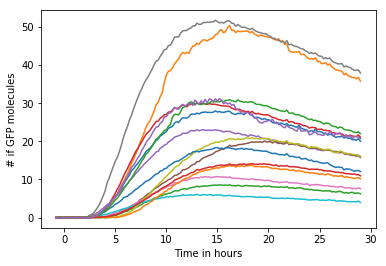

In [38]:
for data in egfp_data[:15]:
    plt.plot(time,data)
plt.xlabel("Time in hours")
plt.ylabel("# if GFP molecules")

In [7]:
def egfp_expression(t,ktm,delta,beta,t0):
    result = ktm/(delta-beta)*(1-np.exp(-(delta-beta)*(t-t0)))*np.exp(-beta*(t-t0))
    result[t<t0]=0
    return result

In [8]:
def egfp_2stage(para,t,data=None,eps=None):
    ktm = para['ktm']
    delta = para['delta']
    beta = para['beta']
    t0 = para['t0']
    result = ktm/(delta-beta)*(1-np.exp(-(delta-beta)*(t-t0)))*np.exp(-beta*(t-t0))
    result[t<t0]=0
    if data is None:
        return result
    if eps is None:
        return result-data
    return (result-data)/eps

In [9]:
def threestage(t,t0,ktl,km,delta,beta,off=0):
    km=np.abs(km)
    ktl=np.abs(ktl)
    delta=np.abs(delta)
    beta=np.abs(beta)
    dmb = delta-beta
    bkm = beta + km
    dmbk = delta-bkm
    t0=np.abs(t0)
    dt=t-t0
    result = 1/dmb +km*np.exp(-dmb*dt)/dmb/dmbk-np.exp(-km*dt)/dmbk
    result = ktl*np.exp(-beta*dt)*result.clip(0)
    result[t<t0]=0
    return off+result
threestage_model = lm.Model(threestage)

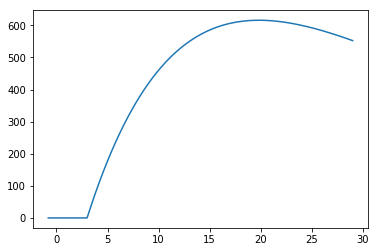

In [10]:
plt.plot(time,egfp_expression(time,100,0.05,0.07,3))

In [11]:
egfp_mod = lm.Model(egfp_expression)

In [39]:
data = egfp_data[11]

[[Model]]
    Model(egfp_expression)
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 358
    # data points      = 150
    # variables        = 4
    chi-square         = 17.2101231
    reduced chi-square = 0.11787756
    Akaike info crit   = -316.770630
    Bayesian info crit = -304.728089
[[Variables]]
    ktm:    3.23468173 (init = 3)
    delta:  0.08916130 (init = 0.05)
    beta:   0.08915490 (init = 0.07)
    t0:     6.89057728 (init = 6)

[[Model]]
    Model(egfp_expression)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 74
    # data points      = 150
    # variables        = 4
    chi-square         = 17.2101227
    reduced chi-square = 0.11787755
    Akaike info crit   = -316.770633
    Bayesian info crit = -304.728092
[[Variables]]
    ktm:    3.23467076 +/- 0.03397579 (1.05%) (init = 3)
    delta:  0.08914950 +/- 8.21072156 (9210.06%) (init = 0.05)
    beta:   0.08916562 +/- 8.21002511 (9207.61%) (init = 0.07)
   

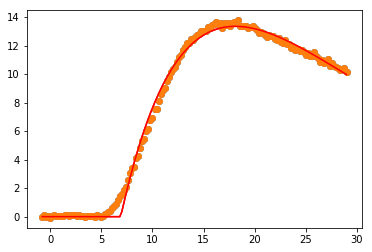

In [17]:
pars = egfp_mod.make_params()
pars['ktm'].set(value=3,vary=True,min=0)
pars['delta'].set(value=0.05,vary=True,min=0)
pars['beta'].set(value=0.07,vary=True,min=0)
pars['t0'].set(value=6,vary=True,min=0)

result0 = egfp_mod.fit(data,pars,t=time,method='nelder')

print(result0.fit_report())

plt.plot(time,data,"o")
plt.plot(time, result0.best_fit, 'r-')

result = egfp_mod.fit(data,pars,t=time,method='leastsq')

print(result.fit_report())

plt.plot(time,data,"o")
plt.plot(time, result.best_fit, 'r-')


In [14]:
p = lm.Parameters()
p.add('ktm',value=3,vary=True,min=0)
p.add('delta',value=0.05,vary=True,min=0)
p.add('beta',value=0.07,vary=True,min=0)
p.add('t0',value=6,vary=True,min=0)

# create Minimizer
mini = lm.Minimizer(egfp_2stage, p, fcn_args=(time,data),nan_policy='omit')

out1 = mini.minimize(method='nelder')

out2 = mini.minimize(method='leastsq',params=out1.params)

lm.report_fit(out2.params, min_correl=0.5)
out2.params.pretty_print()

[[Variables]]
    ktm:    3.23466560 +/- 0.03300636 (1.02%) (init = 3.234682)
    delta:  0.08918609 +/- 7.93738752 (8899.80%) (init = 0.0891613)
    beta:   0.08912880 +/- 7.93711908 (8905.22%) (init = 0.0891549)
    t0:     6.89058261 +/- 0.04043149 (0.59%) (init = 6.890577)
[[Correlations]] (unreported correlations are < 0.500)
    C(delta, beta) = -1.000
    C(ktm, t0)     =  0.671
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
beta    0.08913        0      inf    7.937     True     None     None
delta   0.08919        0      inf    7.937     True     None     None
ktm       3.235        0      inf  0.03301     True     None     None
t0        6.891        0      inf  0.04043     True     None     None


Text(0,0.5,'beta')

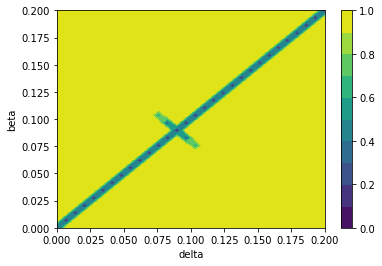

In [15]:
cx, cy, grid = lm.conf_interval2d(mini, out2, 'delta', 'beta', 30, 30,limits=((.2,0), (.2, 0)))
plt.contourf(cx, cy, grid, np.linspace(0, 1, 11))
plt.xlabel('delta')
plt.colorbar()
plt.ylabel('beta')

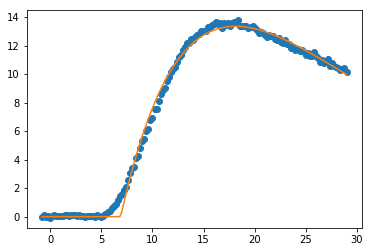

In [18]:
plt.plot(time,data,"o")
plt.plot(time,egfp_2stage(out2.params,time))

[[Model]]
    Model(threestage)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 302
    # data points      = 150
    # variables        = 6
    chi-square         = 3.91300637
    reduced chi-square = 0.02717366
    Akaike info crit   = -534.949398
    Bayesian info crit = -516.885586
[[Variables]]
    t0:     5.62770234 +/- 0.04490520 (0.80%) (init = 5)
    ktl:    7.11814044 +/- 305.440168 (4291.01%) (init = 3)
    km:     0.26111264 +/- 11.2028120 (4290.41%) (init = 3)
    delta:  0.30376690 +/- 11.1995901 (3686.90%) (init = 0.05)
    beta:   0.04276472 +/- 0.00126986 (2.97%) (init = 0.07)
    off:    0.10908424 +/- 0.02794767 (25.62%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(ktl, km)    = -1.000
    C(ktl, delta) =  1.000
    C(km, delta)  = -1.000
    C(t0, beta)   = -0.574
    C(t0, off)    =  0.391
    C(t0, km)     =  0.208
    C(t0, ktl)    = -0.208
    C(t0, delta)  = -0.207



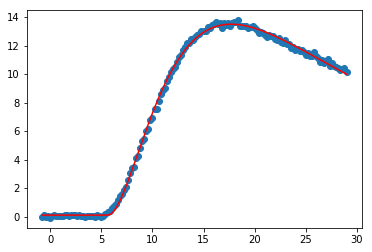

In [19]:
pars = threestage_model.make_params()
pars['km'].set(value=3,vary=True,min=0)
pars['ktl'].set(value=3,vary=True,min=0)
pars['delta'].set(value=0.05,vary=True,min=0)
pars['beta'].set(value=0.07,vary=True,min=0)
pars['t0'].set(value=5,vary=True,min=0)

result = threestage_model.fit(data,pars,t=time)

print(result.fit_report())

plt.plot(time,data,"o")
plt.plot(time, result.best_fit, 'r-')